In [40]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [41]:
# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [42]:
DATASET = r'dataset\\signal_data_full.xlsx'

In [43]:
df = pd.read_excel(DATASET)

In [44]:
df.fillna(0, inplace=True)

In [45]:
df.drop(columns=['Объект'], inplace=True)

In [46]:
df['Дата'] = pd.to_datetime(df['Дата']).dt.normalize()

In [47]:
df.set_index('Дата', inplace=True)

In [48]:
df_agg = df.groupby('Дата').sum()

In [49]:
df_agg["ВП"] = df_agg["Серийное производство"] + df_agg["Программа выполняется"]
df_agg["ВРО"] = df_agg["ВП"] + df_agg["Прогрев станка"] + df_agg["Отработка программы"] + df_agg["Ручной режим"] + df_agg["Станок включен"]

df_agg["ВРП"] = df_agg["ВРО"] + df_agg["Наладка"] + df_agg["Контроль ОТК"]+ df_agg["Регламентированный перерыв"]+ df_agg["Уборка оборудования"]+ df_agg["Сервисное обслуживание"]+ df_agg["Отсутствие заготовки"]+ df_agg["Отсутствие программы"]+ df_agg["Отсутствие инструмента"]+ df_agg["Отсутствие КД/модели"]+ df_agg["Ремонтные работы"]+ df_agg["Авария"]+ df_agg["Аварийная остановка"]

df_agg["OEE"] = df_agg["ВРО"] / df_agg["ВРП"] * df_agg["ВП"] / df_agg["ВРО"] * 0.95

In [50]:
exclude_columns = ["Производительность", "Доступность", "ВРО", "ВРП", "ВП"]
df_agg.drop(exclude_columns, axis=1, inplace=True, errors="ignore")

In [51]:
# Рассчитываем порог для NaN и 0
threshold = len(df_agg) * 0.2

# Удаляем столбцы, где количество NaN или 0 больше 50%
columns_0_more_20_per = [
    col
    for col in df_agg.columns
    if df_agg[col].isna().sum() > threshold or (df_agg[col] == 0).sum() > threshold
]

df_cleaned = df_agg.drop(columns=columns_0_more_20_per)

# Теперь df_cleaned содержит только те столбцы, где количество NaN и 0 не превышает 50%

In [52]:
pt = PowerTransformer(method='yeo-johnson')
df_cleaned[df_cleaned.drop(["OEE"], axis=1).columns] = pt.fit_transform(df_cleaned.drop(["OEE"], axis=1))

In [53]:
#Выбираем целевые переменные
target_columns = ["OEE"]

In [54]:
correlation_matrix_oee = df_cleaned.corr()

# Определение экзогенных переменных (корреляция > 0.2)

exog_vars_oee = correlation_matrix_oee["OEE"].drop("OEE").abs()

exog_columns_oee = exog_vars_oee[exog_vars_oee > 0.3].index.tolist()

# Создание словаря с экзогенными переменными
exog_variables_dict = {
    "OEE": exog_columns_oee
}

# Вывод словаря
exog_variables_dict

{'OEE': ['Программа выполняется']}

In [55]:
def preprocess_data(data, target, exog_columns=None, lag_start=1, lag_end=7, test_size=0.2):
    data = pd.DataFrame(data.copy())

    # --- Создаем лаги для целевой переменной ---
    for i in range(lag_start, lag_end+1):
        data[f"lag_{i}"] = data[target].shift(i)

    # --- Создаем лаги для экзогенных переменных ---
    if exog_columns is not None:
        for col in exog_columns:
            for i in range(lag_start, lag_end+1):
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    else:
        for col in data.drop(target, axis=1).columns.to_list():
            for i in range(lag_start, lag_end+1):
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    

    data = data.dropna()

    # --- Добавляем временные признаки ---
    data["day_of_week"] = data.index.dayofweek
    data["month"] = data.index.month
    data["date"] = data.index.day.astype(int)  # Числовой формат
    
    # --- Добавляем колонку "holiday" ---
    ru_holidays = holidays.RU(years=data.index.year.unique())  # Автоматический поиск праздников
    data["holiday"] = data.index.map(lambda x: 1 if x in ru_holidays else 0)

    # --- Добавляем скользящее среднее ---
    data["rolling_mean_7"] = data[target].rolling(7).mean()
    data["rolling_mean_14"] = data[target].rolling(14).mean()
    data["rolling_mean_30"] = data[target].rolling(30).mean()

    # --- Удаляем NaN после добавления лагов и скользящих средних ---
    data.dropna(inplace=True)

    # --- Рассчитываем средние по времени ---
    size = int(len(data) * (1 - test_size))

    date_means = data.groupby('date')[target].mean()

    data['date_average'] = data['date'].map(date_means)

    # --- Удаляем лишние колонки ---
    
    # --- Разделение на train/test ---
    X_train = data.iloc[:size].drop(target, axis=1)
    X_test = data.iloc[size:].drop(target, axis=1)
    y_train = data[target].iloc[:size]
    y_test = data[target].iloc[size:]

    return X_train, X_test, y_train, y_test

In [56]:

TEST_SIZE = 0.2
LAG = 60
X_train, X_test, y_train, y_test = preprocess_data(df_cleaned, target='OEE', lag_end=LAG, exog_columns=None, test_size=TEST_SIZE)

C:\Users\admin\AppData\Local\Temp\ipykernel_4780\2466282475.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_lag_{i}'] = data[col].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_4780\2466282475.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_lag_{i}'] = data[col].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_4780\2466282475.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [57]:
# bm_params = next(item["best_params"] for item in results if item["model"] == "CatBoostRegressor")
# bm_params = df_results['best_params'][0]
# bm_name = df_results['model'][0]
bm_params = {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 7, 'model__iterations': 200, 'model__depth': 4}
bm_name = 'CatBoostRegressor'
print(bm_params)

{'model__learning_rate': 0.05, 'model__l2_leaf_reg': 7, 'model__iterations': 200, 'model__depth': 4}


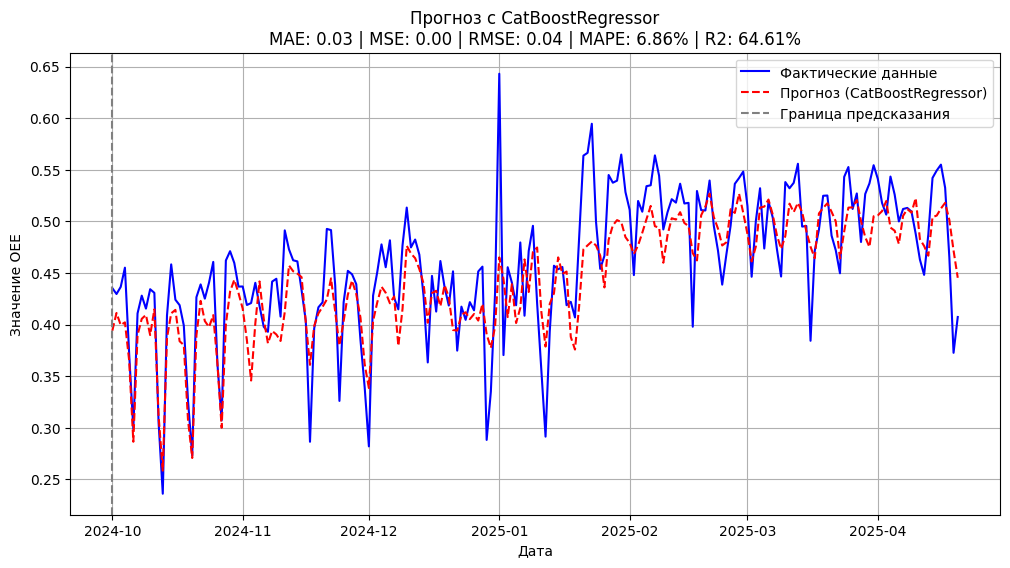

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

RANDOM_SEED = 42
# --- Убираем префикс "model__" из bm_params ---
cleaned_bm_params = {k.replace("model__", ""): v for k, v in bm_params.items()}

# --- Обучение модели с лучшими параметрами через Pipeline ---
best_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(**cleaned_bm_params, verbose=0, random_seed=RANDOM_SEED, has_time=True))
])

best_pipeline.fit(X_train, y_train)  # Обучаем

# --- Прогнозирование ---
final_preds = best_pipeline.predict(X_test)

# --- Вычисление метрик ---
mae = mean_absolute_error(y_test, final_preds)
mse = mean_squared_error(y_test, final_preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

# --- Визуализация прогноза ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические данные", color="blue")
plt.plot(y_test.index, final_preds, label=f"Прогноз ({bm_name})", color="red", linestyle="dashed")

plt.axvline(x=y_test.index[0], color="gray", linestyle="--", label="Граница предсказания")
plt.legend()
plt.title(f"Прогноз с {bm_name}\n"
          f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2%} | R2: {r2:.2%}")
plt.xlabel("Дата")
plt.ylabel("Значение OEE")
plt.grid(True)
plt.show()

DatetimeIndex(['2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
               '2025-04-25', '2025-04-26', '2025-04-27', '2025-04-28',
               '2025-04-29', '2025-04-30', '2025-05-01', '2025-05-02',
               '2025-05-03', '2025-05-04', '2025-05-05', '2025-05-06',
               '2025-05-07', '2025-05-08', '2025-05-09', '2025-05-10',
               '2025-05-11', '2025-05-12', '2025-05-13', '2025-05-14',
               '2025-05-15', '2025-05-16', '2025-05-17', '2025-05-18',
               '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22',
               '2025-05-23', '2025-05-24', '2025-05-25', '2025-05-26',
               '2025-05-27', '2025-05-28', '2025-05-29', '2025-05-30',
               '2025-05-31', '2025-06-01', '2025-06-02', '2025-06-03',
               '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-07',
               '2025-06-08', '2025-06-09', '2025-06-10', '2025-06-11',
               '2025-06-12', '2025-06-13', '2025-06-14', '2025-06-15',
      

[0.4452942636922895,
 0.49426447416450686,
 0.2860639964706457,
 0.5061872043656558,
 0.4772299323996744,
 0.4835740261279122,
 0.42874159535201817,
 0.4661155604371076,
 0.4726586696412838,
 0.46737369178542715,
 0.4870131547779699,
 0.48625366747838117,
 0.49419044764777653,
 0.4883345155110165,
 0.4790307784392344,
 0.4734863305701186,
 0.4863872533252429,
 0.503512210723673,
 0.47919350727193427,
 0.4743352347890587,
 0.47742918892883696,
 0.4697504994450008,
 0.47242264107403087,
 0.4853004187780203,
 0.4955170441835547,
 0.4861117977902485,
 0.48421120622094554,
 0.46603693158202697,
 0.4822221501439539,
 0.47630718890173007,
 0.4856673768169478,
 0.4987769889859593,
 0.48042136774534894,
 0.4857028542182962,
 0.44112245525449717,
 0.4851043717320426,
 0.4711361413882525,
 0.49856427329524317,
 0.48900519726898517,
 0.4769059840519352,
 0.49598779320795733,
 0.4685871682897086,
 0.48028053334825066,
 0.48680122230855244,
 0.49869196025118867,
 0.4946981665562064,
 0.4790455170515

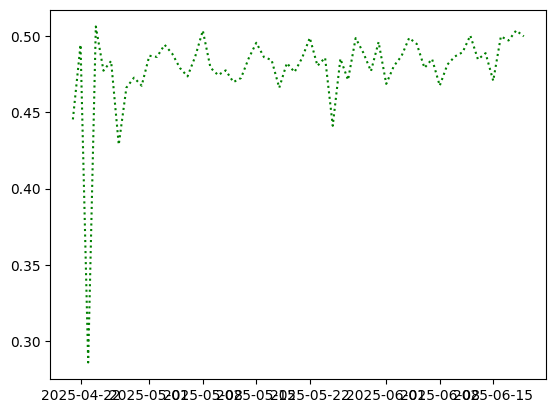

In [63]:
# --- Итеративный прогноз на 30 дней вперед ---
forecast_horizon = 60
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

# Копируем последнюю строку X_test как основу для прогнозирования
last_known_data = X_test.iloc[-1:].copy()
future_preds = []

for _ in range(forecast_horizon):
    next_pred = best_pipeline.predict(last_known_data)[0]  # Прогноз следующего дня
    future_preds.append(next_pred)
    
    # Сдвигаем лаги: удаляем самый старый лаг и добавляем новое предсказанное значение
    last_known_data = last_known_data.shift(-1, axis=1)  # Сдвиг всех лагов
    last_known_data.iloc[:, -1] = next_pred  # Добавляем новый прогноз в самый свежий лаг

display(future_dates, future_preds)
plt.plot(future_dates, future_preds, label=f"Прогноз ({forecast_horizon} дней)", color="green", linestyle="dotted")